In [11]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# Pandas setting
pd.options.plotting.backend = "plotly"
pd.options.mode.chained_assignment = None

In [12]:
# Import dataset
df = pd.read_csv('datasets/theses_v2.csv', encoding='latin-1', low_memory=False)
df.replace('', np.NaN, inplace=True)

In [13]:
import re

# Pre-processing
df['Auteur'] = df['Auteur'].apply(lambda s: re.sub('\([^\)]+\)', '', s.title()).rstrip())

df['Identifiant auteur'] = df['Identifiant auteur'].apply(lambda x: str(x).replace(',', ''))
df['Identifiant auteur'].replace({'nan' : np.nan, '' : np.nan}, inplace = True)

df['Identifiant directeur'] = df['Identifiant directeur'].apply(lambda x: str(x).replace(',', ''))
df['Identifiant directeur'].replace({'na' : np.nan, '' : np.nan}, inplace = True)

df['Supervisor'] = df['Directeur de these (nom prenom)'].str.title()
df['Supervisor'].replace({'Directeur De These Inconnu' : np.nan}, inplace = True)
df.drop(columns=['Directeur de these', 'Directeur de these (nom prenom)'], inplace=True)

# Missing Data

Create number of pages column

In [14]:
from scipy.stats import bernoulli as bn

mu, sigma = 200, 50
pages = sigma * np.random.randn(1, df.shape[0]) + mu

flag = bn.rvs(p = 0.8, size = (1, df.shape[0]))
pages[flag == 0] = np.nan

df['nb_pages'] = pages.ravel() # Number of pages column

In [15]:
print(df.isna().mean().round(4) * 100)

Auteur                                       0.00
Identifiant auteur                          29.14
Titre                                        0.00
Identifiant directeur                       10.98
Etablissement de soutenance                  0.00
Identifiant etablissement                    3.82
Discipline                                   0.00
Statut                                       0.00
Date de premiere inscription en doctorat    85.71
Date de soutenance                          12.68
Year                                        12.68
Langue de la these                          14.24
Identifiant de la these                      0.00
Accessible en ligne                          0.00
Publication dans theses.fr                   0.00
Mise a jour dans theses.fr                   0.04
Supervisor                                   0.16
nb_pages                                    20.05
dtype: float64


Missing data plot

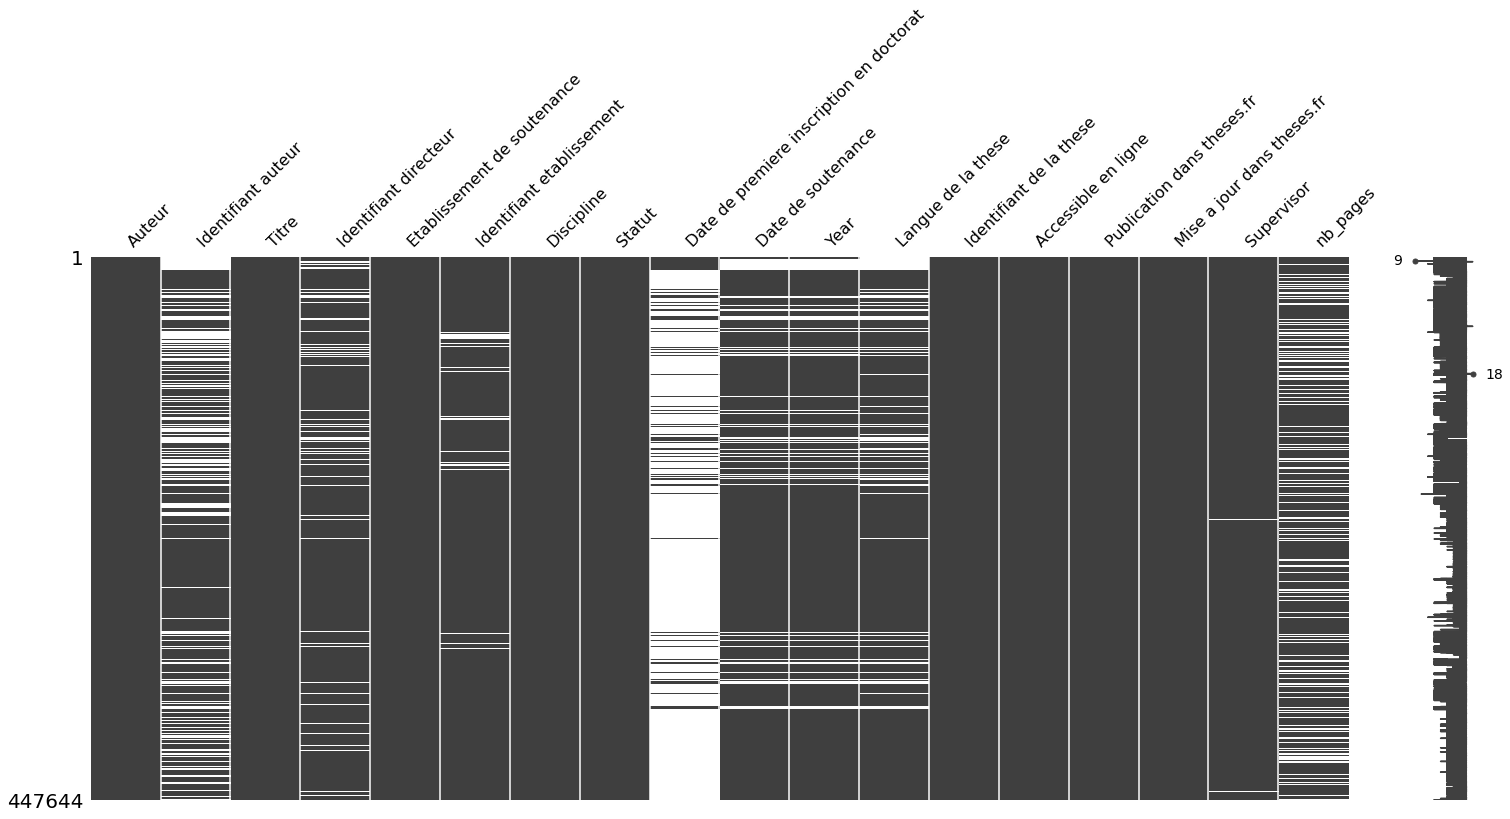

In [16]:
import missingno as msno

msno.matrix(df)
plt.savefig("plots/missing_plot.png")

Dealing with missing data using imputation technique

In [17]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['nb_pages'] = imp.fit_transform(df[['nb_pages']]).ravel()
df['nb_pages'] = df['nb_pages'].apply(int)

# Common issues

In [18]:
df_defences = df.dropna(subset=['Date de soutenance'])
df_defences['Date de soutenance'] = pd.DatetimeIndex(df_defences['Date de soutenance'])
df_defences['Month'] = df_defences['Date de soutenance'].apply(lambda x: x.month)

years = df_defences.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

### How common are the defences on the ﬁrst of January?

In [19]:
df_0101 = df_defences[df_defences['Date de soutenance'].apply(lambda x: np.logical_and(x.day == 1, x.month == 1))]

percentage_thesis_0101 = np.round(df_0101.shape[0] / df_defences.shape[0], 4) * 100
print(percentage_thesis_0101, '%')

71.89 %


### How did the proportion of defences at the ﬁrst of january evolve over the years ?

In [21]:
df_0101 = df_0101.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1)
df_0101.rename(columns={'Titre' : 'nb_Thesis'}, inplace=True)
df_0101['nb_Thesis_byyear'] = df_0101['Year'].apply(lambda x: years.loc[x])
df_0101['Percentage'] = df_0101['nb_Thesis'] / df_0101['nb_Thesis_byyear'] * 100

fig = df_0101.plot(x='Year', y='Percentage', title='Percentage of thesis defended on New Year\'s Day')
fig.write_image('plots/thesis_newyeareve.png')
fig.show()

### In the Author name, how common are homonyms ? Check for Cecile Martin. Investigate her case and try to ﬁgure out what happened.

In [22]:
print(df['Auteur'].duplicated(keep=False).mean().round(4) * 100,'%')

7.66 %


In [23]:
df['Auteur'].value_counts().head(10)

Philippe Martin    16
Nicolas Martin     16
Philippe Michel    13
Yang Liu           12
Franck Martin      12
Laurent Martin     11
Jing Wang          11
Pierre Martin      11
Olivier Martin     11
Yu Wang            11
Name: Auteur, dtype: int64

In [24]:
df[df['Auteur'] == 'Cecile Martin']

,Auteur,Identifiant auteur,Titre,Identifiant directeur,Etablissement de soutenance,Identifiant etablissement,Discipline,Statut,Date de premiere inscription en doctorat,Date de soutenance,Year,Langue de la these,Identifiant de la these,Accessible en ligne,Publication dans theses.fr,Mise a jour dans theses.fr,Supervisor,nb_pages
61289,Cecile Martin,203208145,L'invention de l'ecran. De l'ecran de cheminee...,34210393,Sorbonne Paris Cite,19077990X,Etudes cinematographiques et audiovisuelles,soutenue,NaN,16-01-17,2017.0,fr,2017USPCA018,non,26-09-11,03-10-17,Jullier Laurent,178
166820,Cecile Martin,81323557,Systeme laitier et filiere lait au mexique : c...,NaN,Institut national agronomique Paris-Grignon,26387859,Sciences biologiques fondamentales et applique...,soutenue,NaN,01-01-00,2000.0,fr,2000INAP0034,non,08-07-17,10-12-19,Lossouarn Jean,240
267565,Cecile Martin,179423568,"Concurrence, prix et qualite de la prise en ch...",29736889,Paris 9,27787109,Sciences economiques,soutenue,NaN,24-01-14,2014.0,fr,2014PA090003,oui,26-09-11,05-12-17,Dormont Brigitte,199
410228,Cecile Martin,81323557,Modelisation et criteres de combustibilite en ...,32192800,Compiegne,26570564,Genie des procedes industriels,soutenue,NaN,01-01-01,2001.0,fr,2001COMP1380,non,24-05-13,08-07-20,Antonini Gerard,230
414771,Cecile Martin,81323557,Caracterisation electrophysiologique et pharma...,95278966,Bordeaux 2,26403005,Neurosciences,soutenue,NaN,01-01-91,1991.0,fr,1991BOR22005,non,24-05-13,07-07-20,Mironneau Jean,215
426351,Cecile Martin,81323557,Influence du ph ruminal sur la digestion des p...,91232910,Clermont-Ferrand 2,26403102,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-94,1994.0,fr,1994CLF21651,non,24-05-13,07-07-20,Briand Yves,199
432070,Cecile Martin,182118703,Deposition d'energie par production de paires ...,32731965,Paris 11,26404664,Physique,soutenue,NaN,01-01-89,1989.0,enfr,1989PA112163,non,26-09-11,07-07-20,Vautherin Dominique,206


### Check for issues in the supervisor’s ID. In what context does the issue appear ? How common is this issue ? Provide a quantitative analysis of it.

In [25]:
df[df['Supervisor'].isna()].head()

,Auteur,Identifiant auteur,Titre,Identifiant directeur,Etablissement de soutenance,Identifiant etablissement,Discipline,Statut,Date de premiere inscription en doctorat,Date de soutenance,Year,Langue de la these,Identifiant de la these,Accessible en ligne,Publication dans theses.fr,Mise a jour dans theses.fr,Supervisor,nb_pages
3431,Choukri Daher Abdi,NaN,NaN,NaN,Lille 1,26404184,NaN,enCours,01-09-12,NaN,NaN,NaN,s88540,non,27-06-13,27-06-13,NaN,199
7684,Domagoj Sabolovic,27116549,Lymphocytologie,NaN,Universite de Nancy I,26403390,Sciences naturelles,soutenue,NaN,01-01-73,1973.0,fr,1973NAN10113,non,13-02-16,12-02-16,NaN,199
7705,Dominique Monein-Langle,169385930,Morphologie et physiologie digestives de la ci...,NaN,Perpignan,26403692,Oceanologie. Biologie marine,soutenue,NaN,01-01-85,1985.0,fr,1985PERP0006,non,17-02-16,16-02-16,NaN,138
7763,Thierry Darrigrand,19091985X,Fractionnement du polyethylene basse densite r...,NaN,Pau,NaN,Chimie physique,soutenue,NaN,01-01-87,1987.0,fr,1987PAUU1007,non,11-03-16,10-03-16,NaN,253
11664,Mohsen Selmi,175387222,Differenciation des sols et fonctionnement des...,NaN,Nancy 1,26403390,Sciences naturelles,soutenue,NaN,01-01-85,1985.0,fr,1985NAN10430,non,13-06-17,12-06-17,NaN,199


# Outliers

Check Supervisor ID

In [26]:
df['Identifiant directeur'].value_counts().head(10)

1           1057
7            718
3            712
8            618
6            557
2            517
9            284
59375140     208
26730774     205
26756625     193
Name: Identifiant directeur, dtype: int64

In [27]:
df_outliers = df[df['Identifiant directeur'].str.len() == 1]
print(df_outliers.shape[0]) # Number of thesis supervised by top 7 ID

4587


In [28]:
print(df_outliers.groupby('Supervisor').count().shape[0]) # Number of different supervisors attached to 7 ID

4504


Investigate ID 59375140

In [29]:
df[df['Identifiant directeur'] == '59375140'].head(10)

,Auteur,Identifiant auteur,Titre,Identifiant directeur,Etablissement de soutenance,Identifiant etablissement,Discipline,Statut,Date de premiere inscription en doctorat,Date de soutenance,Year,Langue de la these,Identifiant de la these,Accessible en ligne,Publication dans theses.fr,Mise a jour dans theses.fr,Supervisor,nb_pages
90380,Ramzi Shawahna,158089014,Expression genomique et proteomique quantitati...,59375140,Paris 5,26404788,Pharmacologie cellulaire et moleculaire,soutenue,NaN,01-01-11,2011.0,en,2011PA05P622,non,24-05-13,10-04-19,Scherrmann Jean-Michel,182
91570,Leonor Vignol,NaN,Influence des variabilites pharmacocinetique e...,59375140,Paris 5,NaN,Pharmacie,soutenue,NaN,01-01-01,2001.0,fr,2001PA05P043,non,24-05-13,10-04-19,Scherrmann Jean-Michel,151
97927,Anne J. Moulin Paccaly,97663662,Approches pharmacocinetiques/pharmacodynamique...,59375140,Paris 5,26404788,Pharmacie,soutenue,NaN,01-01-05,2005.0,fr,2005PA05P630,non,24-05-13,14-04-19,Scherrmann Jean-Michel,290
98808,Sandrine Dauchy,87464918,"Expression, localisation et regulation des tra...",59375140,Paris 5,26404788,Pharmacie,soutenue,NaN,01-01-08,2008.0,fr,2008PA05P652,non,24-05-13,14-04-19,Scherrmann Jean-Michel,196
103898,Severine Piot,NaN,Evaluation de 2 associations comportant du doc...,59375140,Paris 5,26404788,Pharmacie,soutenue,NaN,01-01-99,1999.0,fr,1999PA05P078,non,24-05-13,30-04-19,Scherrmann Jean-Michel,174
104937,Sandrine Brami,NaN,Les interactions medicamenteuses avec les inhi...,59375140,Paris 5,26404788,Pharmacie,soutenue,NaN,01-01-99,1999.0,fr,1999PA05P143,non,24-05-13,30-04-19,Scherrmann Jean-Michel,174
107340,Frederique Stain Texier,NaN,Contribution a la recherche du mecanime de l'a...,59375140,Paris 6,27787087,Sciences medicales,soutenue,NaN,01-01-99,1999.0,fr,1999PA066484,non,24-05-13,30-04-19,Scherrmann Jean-Michel,233
112724,Pierre Got,NaN,Immuno-analyse et chiralite. Facteurs influenc...,59375140,Paris 6,27787087,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-97,1997.0,fr,1997PA066359,non,24-05-13,06-05-19,Scherrmann Jean-Michel,258
141777,Christophe Junot,NaN,Le tetrapeptide acetyl-seryl-aspartyl-lysyl-pr...,59375140,Paris 6,27787087,Sciences medicales,soutenue,NaN,01-01-00,2000.0,fr,2000PA066237,non,24-05-13,30-04-19,Scherrmann Jean-Michel,191
144232,Stephane Lamy,NaN,Mise au point et validation d'une methode d'ul...,59375140,Paris 5,26404788,Pharmacie,soutenue,NaN,01-01-99,1999.0,fr,1999PA05P215,non,24-05-13,30-04-19,Scherrmann Jean-Michel,237


Check Author ID

In [30]:
df['Identifiant auteur'].value_counts().head(10)

05990190X    12
69413916      7
85924660      6
069632472     6
60151013      6
56833776      5
27013340      5
34296565      5
78079365      5
66761999      5
Name: Identifiant auteur, dtype: int64

Investigate ID 05990190X

In [31]:
df[df['Identifiant auteur'] == '05990190X']

,Auteur,Identifiant auteur,Titre,Identifiant directeur,Etablissement de soutenance,Identifiant etablissement,Discipline,Statut,Date de premiere inscription en doctorat,Date de soutenance,Year,Langue de la these,Identifiant de la these,Accessible en ligne,Publication dans theses.fr,Mise a jour dans theses.fr,Supervisor,nb_pages
198300,"Olivier Costerousse,Philippe Ascher",05990190X,Regulation de l'expression du gene de l'enzyme...,92624839,Paris 6,27787087,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-93,1993.0,fr,1993PA066340,non,24-05-13,29-02-20,Alhenc-Gelas Francois,221
366482,"Mohcine Bennani Mechita,Philippe Ascher",05990190X,Analyse de la contribution de diverses regions...,81129416,Paris 6,27787087,Sciences medicales,soutenue,NaN,01-01-94,1994.0,fr,1994PA066488,non,24-05-13,05-04-19,Elion Jacques,122
373880,"Catherine Genevee-Gaudin,Philippe Ascher",05990190X,Methodes d'etude du recepteur des lymphocytes ...,31794963,Paris 6,27787087,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-93,1993.0,fr,1993PA066555,non,24-05-13,07-07-20,Triebel Frederic,199
377636,"Armelle Helene,Philippe Ascher",05990190X,Analyse structurale du site actif de trois met...,59677716,Paris 6,27787087,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-93,1993.0,fr,1993PA066569,non,24-05-13,07-07-20,Roques B.,199
378116,"Cecile Dufour,Philippe Ascher",05990190X,Heterogeneite genetique de la cardiomyopathie ...,NaN,Paris 6,27787087,Sciences medicales,soutenue,NaN,01-01-95,1995.0,fr,1995PA066075,non,24-05-13,07-07-20,Schwartz K.,199
389849,"Thierry Galli,Philippe Ascher",05990190X,N-acetyl-aspartyl-glutamate et ganglions de la...,53423666,Paris 6,27787087,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-92,1992.0,fr,1992PA066486,non,24-05-13,08-07-20,Glowinski Jacques,251
401866,"Veronique Taupin,Philippe Ascher",05990190X,Modulation de la production de cytokines pro-i...,31863086,Paris 6,27787087,Sciences medicales,soutenue,NaN,01-01-92,1992.0,fr,1992PA066339,non,24-05-13,08-07-20,Zavala Flora,199
407053,"Aymeric Duclert,Philippe Ascher",05990190X,Contribution a l'etude de la regulation des ge...,26777819,Paris 6,27787087,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-94,1994.0,fr,1994PA066356,non,24-05-13,07-07-20,Changeux Jean-Pierre,187
417726,Sylvie Dumas Milne Edwards De Vitry D'Avaucour...,05990190X,Diversite des regulations de l'expression de l...,75968541,Paris 6,27787087,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-93,1993.0,fr,1993PA066662,non,24-05-13,07-07-20,Mallet Jacques,146
418298,"Mohamed Machwate,Philippe Ascher",05990190X,Etude de la formation osseuse dans un modele d...,83249168,Paris 6,27787087,Sciences biologiques et fondamentales applique...,soutenue,NaN,01-01-94,1994.0,fr,1994PA066180,non,24-05-13,07-07-20,Marie P.,117


# Preliminary Results

## Languages and Defense day

In [32]:
# Extract only thesis that has language record from 2011
df_lang = df_defences.drop(df_defences[df_defences['Langue de la these'].isna()].index)
df_lang.drop(df_lang[df_lang['Year'] < 2010].index, inplace=True)

years = df_lang.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [33]:
# Categorize language column to English, French, Multilingual and Others.
df_lang['Langue de la these'] = df_lang['Langue de la these'].str.lower()

conditions  = [ df_lang['Langue de la these'] == 'en', df_lang['Langue de la these'] == 'fr',
                df_lang['Langue de la these'].str.len() > 2]
choices     = [ "English", 'French', 'Multilingual']

df_lang['Langue de la these'] = np.select(conditions, choices, default = 'Others')
years = df_lang.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [34]:
df_lang = df_lang.groupby(['Year', 'Langue de la these']).count().reset_index().reindex(['Year', 'Langue de la these', 'Titre'], axis=1)
df_lang.rename(columns={'Titre' : 'nb_Thesis', 'Langue de la these' : 'Language'}, inplace=True)
df_lang['nb_Thesis_byyear'] = df_lang['Year'].apply(lambda x: years.loc[x])
df_lang['Percentage'] = df_lang['nb_Thesis'] / df_lang['nb_Thesis_byyear'] * 100

In [35]:
fig = px.bar(df_lang, x="Year", y="Percentage", color="Language", title="Language of thesis by Year")
fig.write_image("plots/language_by_year.png")
fig.show()

What period of the year do PhD candidates tend to defend?

In [36]:
# Extract only thesis that's defended from 2011
df_months = df_defences[df_defences['Date de soutenance'].apply(lambda x: np.logical_and(x.year > 2010, np.logical_or(x.day != 1, x.month != 1)))]

years = df_months.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [37]:
df_months = df_months.groupby(['Year', 'Month']).count().reset_index().reindex(['Year', 'Month', 'Titre'], axis=1)
df_months.rename(columns={'Titre' : 'nb_Thesis'}, inplace=True)
df_months['nb_Thesis_byyear'] = df_months['Year'].apply(lambda x: years.loc[x])
df_months['Percentage'] = df_months['nb_Thesis'] / df_months['nb_Thesis_byyear'] * 100
df_months['Time'] = pd.to_datetime(df_months[['Year', 'Month']].assign(day=1))

In [38]:
fig = df_months.plot(x='Time', y='Percentage', title='Percentage of thesis defended by month')
fig.write_image("plots/thesis_by_month.png")
fig.show()

In [39]:
fig = df_months.groupby('Month').mean().reset_index().plot.bar(x='Month', y='Percentage', title='Percentage of thesis defended during the year')
fig.write_image("plots/percentage_thesis_during_year.png")
fig.show()

## Gender

In [40]:
import gender_guesser.detector as gender

# Extract only thesis that's defended from 2011
df_gender = df_defences.drop(df_defences[df_defences['Year'] < 2010].index)

detector = gender.Detector()
df_gender[['first_name','last_name']] = df_gender['Auteur'].str.split(' ', 1, expand=True)
df_gender['Gender'] = df_gender['first_name'].apply(lambda s: detector.get_gender(s))
rename_dict = {'mostly_female': 'Female', 'mostly_male': 'Male', 'male' : 'Male', 'female' : 'Female'}
df_gender['Gender'].replace(rename_dict, inplace=True)
df_gender.drop(df_gender[np.logical_or(df_gender['Gender'] == 'unknown', df_gender['Gender'] == 'andy')].index, inplace=True)

years = df_gender.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [41]:
df_gender = df_gender.groupby(['Year', 'Gender']).count().reset_index().reindex(['Year', 'Gender', 'Titre'], axis=1)
df_gender.rename(columns={'Titre' : 'nb_Thesis'}, inplace=True)
df_gender['nb_Thesis_byyear'] = df_gender['Year'].apply(lambda x: years.loc[x])
df_gender['Percentage'] = df_gender['nb_Thesis'] / df_gender['nb_Thesis_byyear'] * 100

In [42]:
fig = px.bar(df_gender, x="Year", y="Percentage", color="Gender", title="Gender of PhD candidates by Year")
fig.write_image("plots/gender_by_year.png")
fig.show()